# Eigenvector Interpretation: What Do the Dimensions Mean?

**Goal:** Interpret the semantic meaning of eigenvectors in the causal metric tensor.

## Configuration

In [26]:
# Data paths
PROJECTIONS_PATH = '../data/vectors/token_eigenbasis_projections_qwen3_4b.pt'
EIGENBASIS_PATH = '../data/vectors/eigenbasis_qwen3_4b.pt'

# Model for tokenizer
MODEL_NAME = 'Qwen/Qwen2.5-3B-Instruct'

# Dimension to analyze
TARGET_DIMENSION = 2559  # Largest eigenvalue, 75% of centroid offset

# Display parameters
N_TOP_TOKENS = 30  # Number of extreme tokens to show
N_SAMPLE_BINS = 10  # Number of bins for sampling across projection range

print(f"Configuration:")
print(f"  Target dimension: {TARGET_DIMENSION}")
print(f"  Model: {MODEL_NAME}")
print(f"  Top tokens to display: {N_TOP_TOKENS}")

Configuration:
  Target dimension: 2559
  Model: Qwen/Qwen2.5-3B-Instruct
  Top tokens to display: 30


## Setup

In [27]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [28]:
print("Loading data...\n")

# Load eigenbasis
print(f"Loading eigenbasis from {EIGENBASIS_PATH}...")
eigenbasis_data = torch.load(EIGENBASIS_PATH, weights_only=False)
eigenvalues = eigenbasis_data['eigenvalues']

# Load token projections
print(f"Loading projections from {PROJECTIONS_PATH}...")
projections_data = torch.load(PROJECTIONS_PATH, weights_only=False)
projections = projections_data['projections']  # [vocab_size, hidden_dim]

vocab_size, hidden_dim = projections.shape

# Load tokenizer
print(f"Loading tokenizer for {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"\n✓ Data loaded")
print(f"  Vocab size: {vocab_size:,}")
print(f"  Hidden dim: {hidden_dim:,}")
print(f"  Target dimension eigenvalue: {eigenvalues[TARGET_DIMENSION].item():,.0f}")

Loading data...

Loading eigenbasis from ../data/vectors/eigenbasis_qwen3_4b.pt...
Loading projections from ../data/vectors/token_eigenbasis_projections_qwen3_4b.pt...
Loading tokenizer for Qwen/Qwen2.5-3B-Instruct...

✓ Data loaded
  Vocab size: 151,936
  Hidden dim: 2,560
  Target dimension eigenvalue: 94,218


In [29]:
# Load causal metric tensor
METRIC_PATH = '../data/vectors/causal_metric_tensor_qwen3_4b.pt'
print(f"Loading causal metric tensor from {METRIC_PATH}...")
metric_data = torch.load(METRIC_PATH, weights_only=False)
M = metric_data['M']  # [hidden_dim, hidden_dim]

# Load actual token embeddings (gamma)
print(f"Loading model to extract token embeddings...")
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained(
    'Qwen/Qwen3-4B-Instruct-2507',
    torch_dtype=torch.float32,
    device_map='cpu'
)
gamma = model.lm_head.weight.data.clone()  # [vocab_size, hidden_dim]

print(f"\n✓ Additional data loaded")
print(f"  Metric tensor shape: {M.shape}")
print(f"  Token embeddings shape: {gamma.shape}")

Loading causal metric tensor from ../data/vectors/causal_metric_tensor_qwen3_4b.pt...
Loading model to extract token embeddings...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


✓ Additional data loaded
  Metric tensor shape: torch.Size([2560, 2560])
  Token embeddings shape: torch.Size([151936, 2560])


---

# Angular Alignment with Dimension 2559 (Causal Metric)

Compute angles between token vectors and the 2559 eigenvector using the **causal metric**.

**Causal cosine similarity:**
```
cos(θ) = (v^T M w) / sqrt((v^T M v)(w^T M w))
```

This measures angles as the model "sees" them in its natural geometry.

In [30]:
# Load eigenvectors and extract target
eigenvectors = eigenbasis_data['eigenvectors']  # [hidden_dim, hidden_dim]
target_eigenvector = eigenvectors[:, TARGET_DIMENSION]  # [hidden_dim]

# Convert to numpy
M_np = M.cpu().numpy()
gamma_np = gamma.numpy()
target_vec = target_eigenvector.numpy()

print("Computing causal angles for all tokens...")
print(f"  (This involves {vocab_size:,} metric tensor operations...)\n")

# Compute causal norm of target eigenvector: sqrt(v^T M v)
target_Mv = M_np @ target_vec
target_norm_causal = np.sqrt(target_vec @ target_Mv)

# Compute gamma @ M in one batch: [vocab_size, hidden_dim]
gamma_M = gamma_np @ M_np

# Compute causal norms for all tokens: sqrt(gamma_i^T M gamma_i)
gamma_M_gamma = np.sum(gamma_M * gamma_np, axis=1)
token_norms_causal = np.sqrt(gamma_M_gamma)

# Compute causal inner products: gamma_i^T M v
causal_inner_products = gamma_M @ target_vec

# Compute causal cosine similarities
cosine_similarity_causal = causal_inner_products / (token_norms_causal * target_norm_causal)

# Convert to angles (in degrees)
cosine_clipped = np.clip(cosine_similarity_causal, -1.0, 1.0)
angles_causal_deg = np.degrees(np.arccos(cosine_clipped))

print(f"✓ Causal angles computed\n")
print(f"Angular statistics (causal metric):")
print(f"  Min angle: {angles_causal_deg.min():.2f}°")
print(f"  Max angle: {angles_causal_deg.max():.2f}°")
print(f"  Mean angle: {angles_causal_deg.mean():.2f}°")
print(f"  Median angle: {np.median(angles_causal_deg):.2f}°")
print(f"\nCausal cosine similarity:")
print(f"  Min: {cosine_similarity_causal.min():+.6f}")
print(f"  Max: {cosine_similarity_causal.max():+.6f}")
print(f"  Mean: {cosine_similarity_causal.mean():+.6f}")
print(f"  Median: {np.median(cosine_similarity_causal):+.6f}")

Computing causal angles for all tokens...
  (This involves 151,936 metric tensor operations...)

✓ Causal angles computed

Angular statistics (causal metric):
  Min angle: 93.88°
  Max angle: 148.70°
  Mean angle: 110.47°
  Median angle: 109.23°

Causal cosine similarity:
  Min: -0.854473
  Max: -0.067687
  Mean: -0.346765
  Median: -0.329310


## Tokens Closest to +2559 Direction

In [31]:
# Find tokens with smallest causal angle (closest to 0°)
top_pos_idx = np.argsort(angles_causal_deg)[:N_TOP_TOKENS]
top_pos_angles = angles_causal_deg[top_pos_idx]
top_pos_cosines = cosine_similarity_causal[top_pos_idx]

print("=" * 110)
print(f"TOP {N_TOP_TOKENS} TOKENS ANGULARLY CLOSEST TO +{TARGET_DIMENSION} (CAUSAL METRIC)")
print("=" * 110)
print(f"{'Rank':<6} {'Token ID':<10} {'Angle':<12} {'Cosine':<15} {'Token String'}")
print("=" * 110)

for rank, (idx, angle, cos_sim) in enumerate(zip(top_pos_idx, top_pos_angles, top_pos_cosines), 1):
    token_str = tokenizer.decode([idx])
    token_display = repr(token_str)
    print(f"{rank:<6} {idx:<10} {angle:>10.2f}°  {cos_sim:>+14.6f}   {token_display}")

TOP 30 TOKENS ANGULARLY CLOSEST TO +2559 (CAUSAL METRIC)
Rank   Token ID   Angle        Cosine          Token String
1      151643          93.88°       -0.067687   '<|endoftext|>'
2      50950           97.81°       -0.135893   '\xa0\n'
3      4102            98.12°       -0.141204   '\xa0'
4      44993          100.17°       -0.176651   '….\n\n'
5      17091          101.06°       -0.191837   ' \xa0'
6      9238           101.55°       -0.200193   '\xa0\xa0'
7      75620          102.01°       -0.208098   ' \xa0 \xa0 \xa0 \xa0'
8      32045          102.02°       -0.208270   ' \xa0 \xa0'
9      72363          102.16°       -0.210593   ' \u200b\u200b'
10     45449          102.36°       -0.214022   '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0'
11     85923          102.56°       -0.217517   '–and'
12     19070          102.56°       -0.217538   '\xa0\xa0\xa0\xa0'
13     45393          102.82°       -0.221815   '\xa0\xa0\xa0'
14     86210          102.90°       -0.223207   '\xa0\xa0\xa0\xa0\xa0\x

## Tokens Closest to -2559 Direction

In [32]:
# Find tokens with largest causal angle (closest to 180°)
top_neg_idx = np.argsort(angles_causal_deg)[::-1][:N_TOP_TOKENS]
top_neg_angles = angles_causal_deg[top_neg_idx]
top_neg_cosines = cosine_similarity_causal[top_neg_idx]

print("=" * 110)
print(f"TOP {N_TOP_TOKENS} TOKENS ANGULARLY CLOSEST TO -{TARGET_DIMENSION} (CAUSAL METRIC)")
print("=" * 110)
print(f"{'Rank':<6} {'Token ID':<10} {'Angle':<12} {'Cosine':<15} {'Token String'}")
print("=" * 110)

for rank, (idx, angle, cos_sim) in enumerate(zip(top_neg_idx, top_neg_angles, top_neg_cosines), 1):
    token_str = tokenizer.decode([idx])
    token_display = repr(token_str)
    print(f"{rank:<6} {idx:<10} {angle:>10.2f}°  {cos_sim:>+14.6f}   {token_display}")

TOP 30 TOKENS ANGULARLY CLOSEST TO -2559 (CAUSAL METRIC)
Rank   Token ID   Angle        Cosine          Token String
1      151666         148.70°       -0.854473   ''
2      151665         148.08°       -0.848788   ''
3      122407         148.01°       -0.848172   '鿍'
4      151667         147.95°       -0.847596   ''
5      150306         147.90°       -0.847086   '숕'
6      122867         147.87°       -0.846866   '𠅤'
7      122290         147.83°       -0.846452   '𦭜'
8      149463         147.82°       -0.846383   '켚'
9      122502         147.80°       -0.846212   '𦙶'
10     150853         147.78°       -0.846050   '겚'
11     151038         147.78°       -0.846005   '쪗'
12     150538         147.78°       -0.845986   'ᕛ'
13     149731         147.78°       -0.845967   '꾈'
14     127572         147.73°       -0.845585   'ו�'
15     123531         147.72°       -0.845476   '𫟦'
16     103907         147.70°       -0.845264   '�'
17     150969         147.67°       -0.845006   '쁭'
1

---

# Survey: Closest Token to Each Eigenvector

For each of the 2560 eigenvector dimensions, find the token that points *closest* to that direction (minimum angle). This shows us which eigenvectors have tokens near them, and which point into empty space.

In [33]:
print("Computing closest token for each eigenvector dimension...")
print(f"  (Processing {hidden_dim} eigenvectors...)\n")

# For each eigenvector, we'll compute angles for all tokens and find the minimum
min_angles = np.zeros(hidden_dim)
max_cosines = np.zeros(hidden_dim)
closest_token_ids = np.zeros(hidden_dim, dtype=int)

# We already computed gamma_M, so we can reuse it
# gamma_M = gamma_np @ M_np  # [vocab_size, hidden_dim]

for dim in range(hidden_dim):
    if dim % 256 == 0:
        print(f"  Processing dimension {dim}/{hidden_dim}...")
    
    # Extract eigenvector for this dimension
    eigenvec = eigenvectors[:, dim].numpy()  # [hidden_dim]
    
    # Compute causal norm of this eigenvector
    eigenvec_Mv = M_np @ eigenvec
    eigenvec_norm = np.sqrt(eigenvec @ eigenvec_Mv)
    
    # Compute causal inner products with all tokens
    inner_products = gamma_M @ eigenvec  # [vocab_size]
    
    # Compute cosine similarities
    cosines = inner_products / (token_norms_causal * eigenvec_norm)
    
    # Find maximum cosine (minimum angle)
    max_idx = np.argmax(cosines)
    max_cosines[dim] = cosines[max_idx]
    closest_token_ids[dim] = max_idx
    
    # Convert to angle
    cos_clipped = np.clip(max_cosines[dim], -1.0, 1.0)
    min_angles[dim] = np.degrees(np.arccos(cos_clipped))

print(f"\n✓ Survey complete\n")

# Display results in a nice table
print("=" * 100)
print("CLOSEST TOKEN TO EACH EIGENVECTOR (CAUSAL METRIC)")
print("=" * 100)
print(f"{'Dimension':<12} {'Min Angle':<12} {'Max Cosine':<15} {'Token ID':<12} {'Token String'}")
print("=" * 100)

for dim in range(hidden_dim):
    angle = min_angles[dim]
    cosine = max_cosines[dim]
    token_id = closest_token_ids[dim]
    token_str = tokenizer.decode([token_id])
    token_display = repr(token_str)
    
    # Truncate long token strings for display
    if len(token_display) > 50:
        token_display = token_display[:47] + "...'"
    
    print(f"{dim:<12} {angle:>10.2f}°  {cosine:>+14.6f}   {token_id:<12} {token_display}")

Computing closest token for each eigenvector dimension...
  (Processing 2560 eigenvectors...)

  Processing dimension 0/2560...
  Processing dimension 256/2560...
  Processing dimension 512/2560...
  Processing dimension 768/2560...
  Processing dimension 1024/2560...
  Processing dimension 1280/2560...
  Processing dimension 1536/2560...
  Processing dimension 1792/2560...
  Processing dimension 2048/2560...
  Processing dimension 2304/2560...

✓ Survey complete

CLOSEST TOKEN TO EACH EIGENVECTOR (CAUSAL METRIC)
Dimension    Min Angle    Max Cosine      Token ID     Token String
0                 82.00°       +0.139184   147930       '🖏'
1                 85.60°       +0.076694   122873       '竫'
2                 86.64°       +0.058686   125472       'ние'
3                 85.69°       +0.075186   122141       '汈'
4                 84.83°       +0.090032   66120        '(cps'
5                 85.43°       +0.079756   113371       '非常多的'
6                 86.84°       +0.055138   12

In [34]:
# Save results to CSV for later analysis
import pandas as pd

# Create DataFrame
df = pd.DataFrame({
    'dimension': np.arange(hidden_dim),
    'min_angle_deg': min_angles,
    'max_cosine': max_cosines,
    'closest_token_id': closest_token_ids,
    'closest_token_str': [tokenizer.decode([int(tid)]) for tid in closest_token_ids],
    'eigenvalue': eigenvalues.numpy()
})

# Save to CSV
output_path = '../data/vectors/eigenvector_closest_tokens_qwen3_4b.csv'
df.to_csv(output_path, index=False)

print(f"✓ Saved to {output_path}")
print(f"\nDataFrame preview:")
print(df.head(10))
print(f"\n... {len(df)} total rows ...")
print(df.tail(10))

✓ Saved to ../data/vectors/eigenvector_closest_tokens_qwen3_4b.csv

DataFrame preview:
   dimension  min_angle_deg  max_cosine  closest_token_id closest_token_str  \
0          0      81.999389    0.139184            147930                 🖏   
1          1      85.601441    0.076694            122873                 竫   
2          2      86.635592    0.058686            125472               ние   
3          3      85.688117    0.075186            122141                 汈   
4          4      84.834556    0.090032             66120              (cps   
5          5      85.425485    0.079756            113371              非常多的   
6          6      86.839219    0.055138            120793                 惆   
7          7      84.932583    0.088328            145378                 🌺   
8          8      85.543793    0.077697            145315                 🎀   
9          9      85.759666    0.073940             27014                ,M   

   eigenvalue  
0   95.352394  
1  314.5947

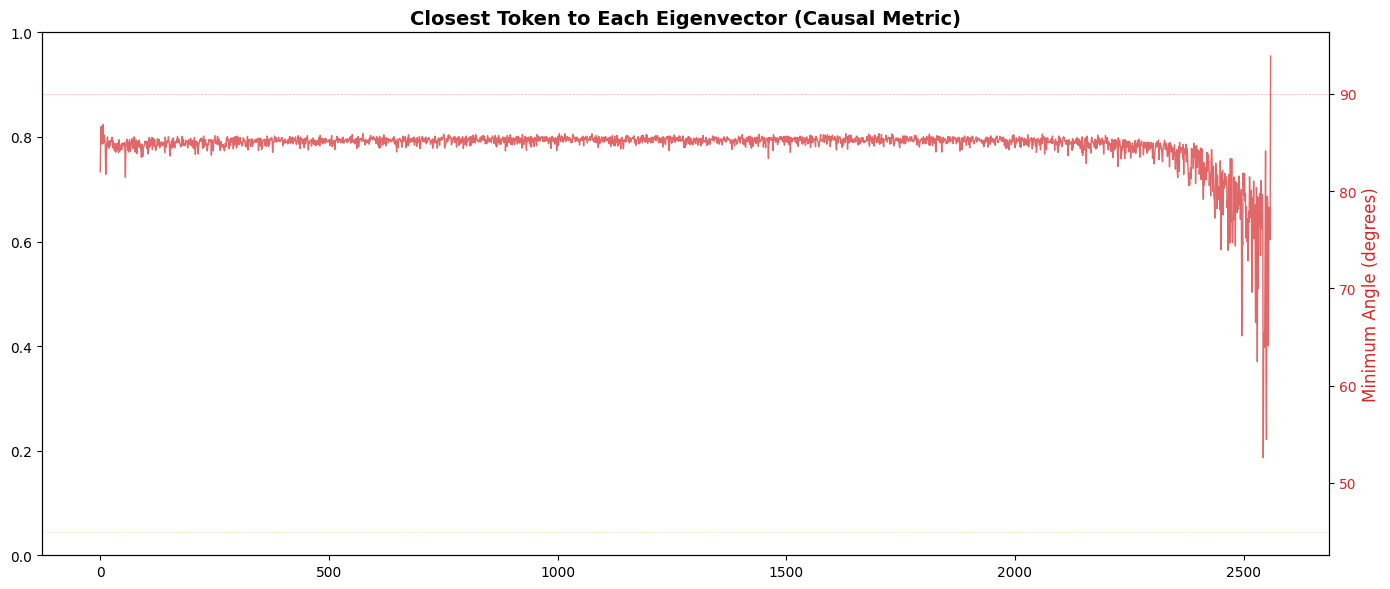


Summary statistics:
  Min angle across all dimensions: 52.57°
  Max angle across all dimensions: 93.88°
  Mean angle: 84.66°
  Median angle: 85.15°

  Best cosine across all dimensions: +0.607738
  Worst cosine across all dimensions: -0.067687
  Mean cosine: +0.092943
  Median cosine: +0.084597

Eigenvectors with closest token at:
  < 45° (fairly aligned): 0
  45-90° (oblique): 2559
  > 90° (obtuse/pointing away): 1


In [35]:
# Plot max cosine (and angle) vs dimension
fig, ax1 = plt.subplots(figsize=(14, 6))

# Left Y-axis: max cosine
# color = 'tab:blue'
# ax1.set_xlabel('Eigenvector Dimension (0 = smallest eigenvalue, 2559 = largest)', fontsize=12)
# ax1.set_ylabel('Max Cosine Similarity', fontsize=12, color=color)
# ax1.plot(df['dimension'], df['max_cosine'], color=color, linewidth=1, alpha=0.7)
# ax1.tick_params(axis='y', labelcolor=color)
# ax1.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.3, label='Perpendicular (90°)')
# ax1.grid(True, alpha=0.3)

# Right Y-axis: angle in degrees
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Minimum Angle (degrees)', fontsize=12, color=color)
ax2.plot(df['dimension'], df['min_angle_deg'], color=color, linewidth=1, alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)

# Add reference lines for common angles
ax2.axhline(90, color='red', linestyle='--', linewidth=0.5, alpha=0.3)
ax2.axhline(45, color='orange', linestyle='--', linewidth=0.5, alpha=0.3)

plt.title('Closest Token to Each Eigenvector (Causal Metric)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary statistics:")
print(f"  Min angle across all dimensions: {df['min_angle_deg'].min():.2f}°")
print(f"  Max angle across all dimensions: {df['min_angle_deg'].max():.2f}°")
print(f"  Mean angle: {df['min_angle_deg'].mean():.2f}°")
print(f"  Median angle: {df['min_angle_deg'].median():.2f}°")
print(f"\n  Best cosine across all dimensions: {df['max_cosine'].max():+.6f}")
print(f"  Worst cosine across all dimensions: {df['max_cosine'].min():+.6f}")
print(f"  Mean cosine: {df['max_cosine'].mean():+.6f}")
print(f"  Median cosine: {df['max_cosine'].median():+.6f}")

# How many eigenvectors have tokens actually close to them?
print(f"\nEigenvectors with closest token at:")
print(f"  < 45° (fairly aligned): {(df['min_angle_deg'] < 45).sum()}")
print(f"  45-90° (oblique): {((df['min_angle_deg'] >= 45) & (df['min_angle_deg'] < 90)).sum()}")
print(f"  > 90° (obtuse/pointing away): {(df['min_angle_deg'] >= 90).sum()}")

## Verification: Double-Check the Math

Let's manually verify a few dimensions to make sure we're computing angles correctly.

In [36]:
# Pick a few test dimensions: low, middle, high
test_dims = [0, 1280, 2559]

print("Manual verification of angle calculations:")
print("=" * 100)

for test_dim in test_dims:
    print(f"\nDimension {test_dim}:")
    print(f"  Eigenvalue: {eigenvalues[test_dim].item():,.0f}")
    
    # Get the eigenvector
    eigenvec = eigenvectors[:, test_dim].numpy()
    
    # Compute causal norm of eigenvector: sqrt(v^T M v)
    eigenvec_Mv = M_np @ eigenvec
    eigenvec_norm_causal = np.sqrt(eigenvec @ eigenvec_Mv)
    print(f"  Eigenvector causal norm: {eigenvec_norm_causal:.6f}")
    
    # Get the "closest" token from our survey
    closest_token_id = int(closest_token_ids[test_dim])
    closest_token_vec = gamma_np[closest_token_id]  # [hidden_dim]
    
    # Compute causal norm of this token
    token_Mv = M_np @ closest_token_vec
    token_norm_causal = np.sqrt(closest_token_vec @ token_Mv)
    print(f"  Closest token ({closest_token_id}): {repr(tokenizer.decode([closest_token_id]))}")
    print(f"  Token causal norm: {token_norm_causal:.6f}")
    
    # Compute causal inner product: v^T M w
    causal_inner = closest_token_vec @ (M_np @ eigenvec)
    print(f"  Causal inner product: {causal_inner:.6f}")
    
    # Compute causal cosine similarity
    causal_cosine = causal_inner / (token_norm_causal * eigenvec_norm_causal)
    print(f"  Causal cosine similarity: {causal_cosine:+.6f}")
    
    # Compute angle
    angle_rad = np.arccos(np.clip(causal_cosine, -1.0, 1.0))
    angle_deg = np.degrees(angle_rad)
    print(f"  Angle: {angle_deg:.2f}°")
    
    # Compare to stored values
    stored_angle = min_angles[test_dim]
    stored_cosine = max_cosines[test_dim]
    print(f"\n  Stored angle: {stored_angle:.2f}° (diff: {abs(angle_deg - stored_angle):.6f}°)")
    print(f"  Stored cosine: {stored_cosine:+.6f} (diff: {abs(causal_cosine - stored_cosine):.6f})")
    
    # Also compute Euclidean angle for comparison
    euclidean_inner = closest_token_vec @ eigenvec
    euclidean_norm_token = np.linalg.norm(closest_token_vec)
    euclidean_norm_eigenvec = np.linalg.norm(eigenvec)
    euclidean_cosine = euclidean_inner / (euclidean_norm_token * euclidean_norm_eigenvec)
    euclidean_angle = np.degrees(np.arccos(np.clip(euclidean_cosine, -1.0, 1.0)))
    print(f"\n  Euclidean angle (for comparison): {euclidean_angle:.2f}°")
    print(f"  Euclidean cosine: {euclidean_cosine:+.6f}")

Manual verification of angle calculations:

Dimension 0:
  Eigenvalue: 95
  Eigenvector causal norm: 9.764531
  Closest token (147930): '🖏'
  Token causal norm: 21.523338
  Causal inner product: 29.252014
  Causal cosine similarity: +0.139186
  Angle: 82.00°

  Stored angle: 82.00° (diff: 0.000122°)
  Stored cosine: +0.139184 (diff: 0.000002)

  Euclidean angle (for comparison): 34.52°
  Euclidean cosine: +0.823948

Dimension 1280:
  Eigenvalue: 2,500
  Eigenvector causal norm: 49.995358
  Closest token (68558): 'HELL'
  Token causal norm: 62.634514
  Causal inner product: 251.473251
  Causal cosine similarity: +0.080306
  Angle: 85.39°

  Stored angle: 85.39° (diff: 0.000002°)
  Stored cosine: +0.080306 (diff: 0.000000)

  Euclidean angle (for comparison): 85.46°
  Euclidean cosine: +0.079094

Dimension 2559:
  Eigenvalue: 94,218
  Eigenvector causal norm: 306.949432
  Closest token (151643): '<|endoftext|>'
  Token causal norm: 85.287254
  Causal inner product: -1771.970215
  Causal 

---

# Holy Shit Moment: Are We Looking at the Wrong Eigenvectors?

The causal metric M = Cov(γ)^(-1) has eigenvectors that point in directions of **maximum constraint** (tightest spread).

What if we look at eigenvectors of Cov(γ) itself? Those point in directions of **maximum variance** (where tokens actually spread out).

Maybe we've been staring at the "anti-basis" - the one specifically perpendicular to the data.

In [37]:
# The eigenbasis we've been using is from M = Cov(γ)^(-1)
# Let's compute Cov(γ) = M^(-1) and get ITS eigenvectors

print("Computing covariance matrix eigenvectors...")
print("(This is the INVERSE of the causal metric tensor)\n")

# M_inv = Cov(γ) is just the inverse of M
M_inv = np.linalg.inv(M_np)

# Get eigenvectors and eigenvalues of the COVARIANCE (not inverse covariance)
cov_eigenvalues, cov_eigenvectors = np.linalg.eigh(M_inv)

# eigh returns eigenvalues in ascending order
# Let's reverse to get descending (largest variance first)
cov_eigenvalues = cov_eigenvalues[::-1]
cov_eigenvectors = cov_eigenvectors[:, ::-1]

print(f"✓ Covariance eigenvectors computed\n")
print(f"Covariance eigenvalue range:")
print(f"  Largest: {cov_eigenvalues[0]:,.6f}")
print(f"  Smallest: {cov_eigenvalues[-1]:,.6f}")
print(f"  Ratio: {cov_eigenvalues[0] / cov_eigenvalues[-1]:,.0f}x\n")

# Now check angles to tokens using the COVARIANCE eigenvectors
print("Testing a few covariance eigenvectors...")

for test_idx in [0, 1, 2, 2559]:
    cov_eigenvec = cov_eigenvectors[:, test_idx]
    
    # Compute causal norm
    cov_ev_Mv = M_np @ cov_eigenvec
    cov_ev_norm = np.sqrt(cov_eigenvec @ cov_ev_Mv)
    
    # Compute cosines with all tokens
    inner_prods = gamma_M @ cov_eigenvec
    cosines = inner_prods / (token_norms_causal * cov_ev_norm)
    
    # Find maximum cosine
    max_idx = np.argmax(cosines)
    max_cos = cosines[max_idx]
    min_angle = np.degrees(np.arccos(np.clip(max_cos, -1.0, 1.0)))
    
    token_str = tokenizer.decode([max_idx])
    
    print(f"  Cov eigenvector {test_idx} (eigenvalue {cov_eigenvalues[test_idx]:.2f}):")
    print(f"    Closest token: {repr(token_str)}")
    print(f"    Angle: {min_angle:.2f}°, Cosine: {max_cos:+.6f}")

Computing covariance matrix eigenvectors...
(This is the INVERSE of the causal metric tensor)

✓ Covariance eigenvectors computed

Covariance eigenvalue range:
  Largest: 0.010488
  Smallest: 0.000011
  Ratio: 988x

Testing a few covariance eigenvectors...
  Cov eigenvector 0 (eigenvalue 0.01):
    Closest token: '🖏'
    Angle: 82.00°, Cosine: +0.139192
  Cov eigenvector 1 (eigenvalue 0.00):
    Closest token: '竫'
    Angle: 85.60°, Cosine: +0.076693
  Cov eigenvector 2 (eigenvalue 0.00):
    Closest token: ".',\r\n"
    Angle: 85.24°, Cosine: +0.082954
  Cov eigenvector 2559 (eigenvalue 0.00):
    Closest token: ''
    Angle: 31.30°, Cosine: +0.854474


---

# Curse of Dimensionality Check

Is the ~80-85° thing just because we're in 2560D space, where *everything* is orthogonal?

Let's pick random directions and see if they also have nearest tokens at ~80-85°.

In [38]:
# Generate random directions and find closest token to each
np.random.seed(42)
n_random_directions = 100

print(f"Testing {n_random_directions} random directions...\n")

random_min_angles = []
random_max_cosines = []

for i in range(n_random_directions):
    # Generate random unit vector in embedding space
    random_vec = np.random.randn(hidden_dim)
    random_vec = random_vec / np.linalg.norm(random_vec)  # normalize
    
    # Compute causal norm
    random_vec_Mv = M_np @ random_vec
    random_vec_norm = np.sqrt(random_vec @ random_vec_Mv)
    
    # Compute cosines with all tokens
    inner_prods = gamma_M @ random_vec
    cosines = inner_prods / (token_norms_causal * random_vec_norm)
    
    # Find maximum cosine (minimum angle)
    max_idx = np.argmax(cosines)
    max_cos = cosines[max_idx]
    min_angle = np.degrees(np.arccos(np.clip(max_cos, -1.0, 1.0)))
    
    random_min_angles.append(min_angle)
    random_max_cosines.append(max_cos)

random_min_angles = np.array(random_min_angles)
random_max_cosines = np.array(random_max_cosines)

print(f"✓ Random direction angles computed\n")
print(f"Random directions - closest token angles:")
print(f"  Mean: {random_min_angles.mean():.2f}°")
print(f"  Median: {np.median(random_min_angles):.2f}°")
print(f"  Min: {random_min_angles.min():.2f}°")
print(f"  Max: {random_min_angles.max():.2f}°")
print(f"  Std: {random_min_angles.std():.2f}°")

print(f"\nFor comparison, eigenvector closest token angles:")
print(f"  Mean: {min_angles.mean():.2f}°")
print(f"  Median: {np.median(min_angles):.2f}°")
print(f"  Min: {min_angles.min():.2f}°")
print(f"  Max: {min_angles.max():.2f}°")

print(f"\n{'='*60}")
if abs(random_min_angles.mean() - min_angles.mean()) < 5:
    print("CONCLUSION: Random directions have similar angles to eigenvectors.")
    print("The ~80-85° phenomenon is just high-dimensional geometry!")
    print("The eigenvectors are NOT special in this regard.")
else:
    print("CONCLUSION: Random directions have DIFFERENT angles from eigenvectors.")
    print("The eigenvectors ARE special - they're chosen to maximize/minimize")
    print("something specific about the token distribution.")
print('='*60)

Testing 100 random directions...

✓ Random direction angles computed

Random directions - closest token angles:
  Mean: 84.48°
  Median: 84.64°
  Min: 74.22°
  Max: 91.59°
  Std: 2.85°

For comparison, eigenvector closest token angles:
  Mean: 84.66°
  Median: 85.15°
  Min: 52.57°
  Max: 93.88°

CONCLUSION: Random directions have similar angles to eigenvectors.
The ~80-85° phenomenon is just high-dimensional geometry!
The eigenvectors are NOT special in this regard.
